README:
This model iteration contains the code for the following hyperparameters/metrics:



In [1]:
# this box just gets the metadata of the data we are downloading, 100 each for an initial test
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil
from tqdm import tqdm
import kagglehub

path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

# 1. Load metadata
metadata_path = os.path.join(path, "HAM10000_metadata.csv")
metadata = pd.read_csv(metadata_path)

# 2. Filter to the 3 target classes
target_classes = ['bkl', 'bcc', 'nv']
filtered_metadata = metadata[metadata['dx'].isin(target_classes)]

# 3. Limit each class to 100 images by sampling lesions
limits = {'nv': 100, 'bkl': 100, 'bcc': 100}
selected_metadata = []

for dx in limits:
    class_df = filtered_metadata[filtered_metadata['dx'] == dx]
    lesion_ids = class_df['lesion_id'].drop_duplicates().sample(frac=1, random_state=42)

    selected_lesions = []
    selected_count = 0

    for lesion in lesion_ids:
        lesion_imgs = class_df[class_df['lesion_id'] == lesion]
        if selected_count + len(lesion_imgs) > limits[dx]:
            continue
        selected_lesions.append(lesion)
        selected_count += len(lesion_imgs)
        if selected_count >= limits[dx]:
            break

    subset = class_df[class_df['lesion_id'].isin(selected_lesions)]
    selected_metadata.append(subset)

limited_metadata = pd.concat(selected_metadata).reset_index(drop=True)

print("Limited class distribution:\n", limited_metadata['dx'].value_counts())


Limited class distribution:
 dx
nv     100
bkl    100
bcc    100
Name: count, dtype: int64


In [2]:
# This coding block sets up the training data and validation data to make it model ready

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# target size for images, in this case images already preprocessed from dataset 600X450
IMG_SIZE = (600, 450)

# set number of images per training/test batch
BATCH_SIZE = 16
DATA_DIR = "/content/drive/MyDrive/BME450/Group Project/tiny_dataset"

# set up the training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels = "inferred",
    label_mode = "categorical",
    shuffle = True # shuffle the training data
)

# set up the validation data, same parameters as training
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels = "inferred",
    label_mode = "categorical",
    shuffle = False # do not shuffle the validation data
)

class_names = val_ds.class_names  # Save this before any map()

AUTOTUNE = tf.data.AUTOTUNE
# allows TF to prep next batch while current batch is being processed
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

from tensorflow.keras.applications.resnet50 import preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y:(preprocess_input(x), y))

Found 228 files belonging to 3 classes.
Found 72 files belonging to 3 classes.


In [3]:
class_names

['bcc', 'bkl', 'nv']

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

num_classes = 3

# load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1],3))
base_model.trainable = False # only train the Dense layer first

# custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600, 450,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 606, 456,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 300, 225,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 300, 225,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 300, 225,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 302, 227,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 150, 113,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 150, 113,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 150, 113,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 150, 113,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 150, 113,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 150, 113,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 150, 113,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 150, 113,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 150, 113,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 150, 113,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 150, 113,  │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# **Train the Top Classifier**

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # monitor validation loss
    patience=5,              # stop after 5 epochs with no improvement
    restore_best_weights=True # revert to best weights after stopping
)

In [8]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - AUC: 0.9211 - accuracy: 0.7883 - loss: 0.5291 - precision: 0.7958 - recall: 0.7146 - val_AUC: 0.7749 - val_accuracy: 0.5833 - val_loss: 0.9590 - val_precision: 0.5932 - val_recall: 0.4861
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - AUC: 0.9436 - accuracy: 0.8062 - loss: 0.4574 - precision: 0.8222 - recall: 0.7683 - val_AUC: 0.7773 - val_accuracy: 0.5972 - val_loss: 0.9543 - val_precision: 0.6207 - val_recall: 0.5000
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - AUC: 0.9446 - accuracy: 0.7970 - loss: 0.4557 - precision: 0.8203 - recall: 0.7687 - val_AUC: 0.7780 - val_accuracy: 0.5972 - val_loss: 0.9607 - val_precision: 0.6207 - val_recall: 0.5000
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - AUC: 0.9493 - accuracy: 0.8242 - loss: 0.4400 - precision: 0.8509 - recall: 0.7788 - val_AUC: 0.7688 - val_accuracy: 0.5833 - val_loss: 1.0001 - val_precision: 0.6271 - val_recall: 0.5139
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━

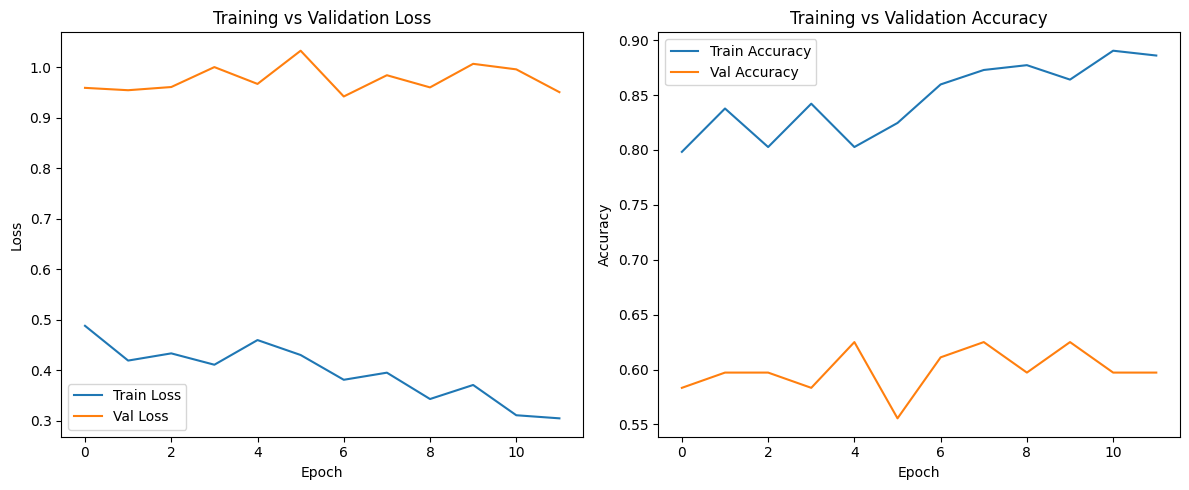

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
import numpy as np

# Get model predictions (probabilities)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = np.concatenate([y for _, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


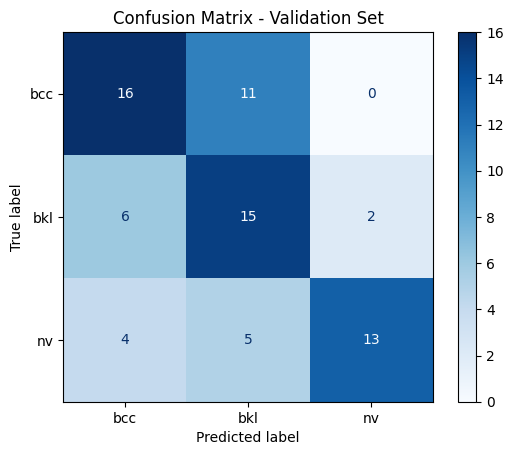

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#class_names = val_ds.class_names  # Gets class labels in correct order
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

# **Fine Tune the Model**

In [14]:
# help the model generalize by unfreezing layers and retraining with a smaller learning rate
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [15]:
history2 = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - AUC: 0.9687 - accuracy: 0.8532 - loss: 0.3567 - precision: 0.8893 - recall: 0.8471 - val_AUC: 0.7929 - val_accuracy: 0.5972 - val_loss: 0.9379 - val_precision: 0.6667 - val_recall: 0.5556
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - AUC: 0.9751 - accuracy: 0.9052 - loss: 0.3206 - precision: 0.9141 - recall: 0.8759 - val_AUC: 0.7832 - val_accuracy: 0.6389 - val_loss: 0.9787 - val_precision: 0.6324 - val_recall: 0.5972
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - AUC: 0.9572 - accuracy: 0.8711 - loss: 0.3999 - precision: 0.8918 - recall: 0.8540 - val_AUC: 0.7878 - val_accuracy: 0.6111 - val_loss: 0.9796 - val_precision: 0.6349 - val_recall: 0.5556
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - AUC: 0.9755 - accuracy: 0.8896 - loss: 0.3178 - precision: 0.8985 - recall: 0.8582 - val_AUC: 0.7867 - val_accuracy: 0.6111 - val_loss: 0.9903 - val_precision: 0.6349 - val_recall: 0.5556
Epoch 5/50
15/15 ━━━━━━━━━━━━━━

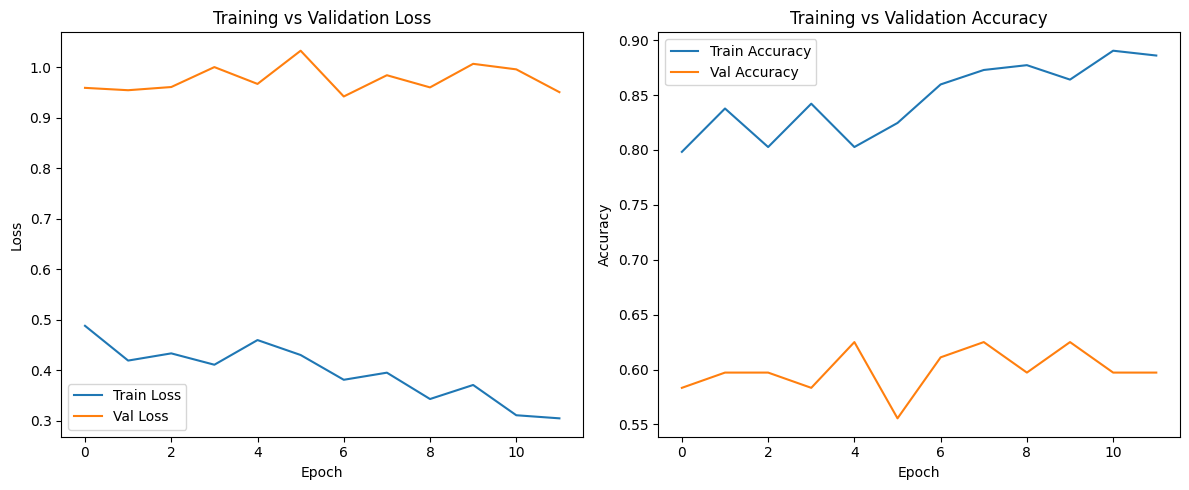

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


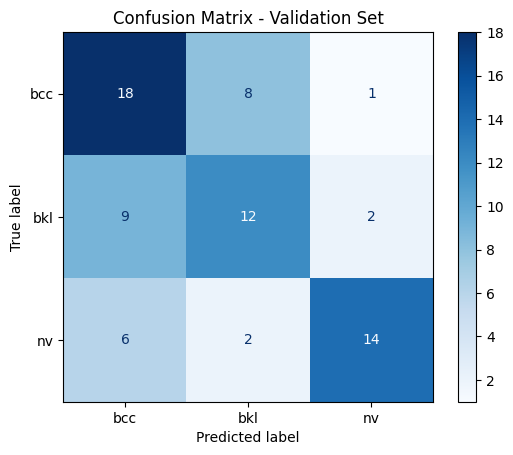

In [17]:
import numpy as np

# Get model predictions (probabilities)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = np.concatenate([y for _, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#class_names = val_ds.class_names  # Gets class labels in correct order
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()